In [1]:
# !pip install torch==1.4.0 torchvision==0.4.1

In [2]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

import torch
from torch.utils.data import DataLoader, Dataset
import torchvision
from torchvision import transforms
from torch.utils.data.sampler import SubsetRandomSampler
from torch import nn
import torch.nn.utils.rnn as rnn_utils
import torch.nn.functional as F
import pickle as pkl
import math
from tqdm import tqdm
import copy
import time
import random

In [3]:
print(torch.__version__ )

1.8.1+cu101


In [23]:
## Mount Google Drive Data (If using Google Colaboratory)
try:
    from google.colab import drive
    drive.mount('/content/gdrive')
except:
    print("Mounting Failed.")

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [24]:
def walk(path):
  if not os.path.exists(path):
    return -1
    for root, dirs, names in os.walk(path):
      for filename in names:
        print(os.path.join(root,filename))

In [5]:
def findNearestSmallerTime(refTime, location_msg):
  left = 0
  right = len(location_msg) - 1
  Time = location_msg["Time"]
  while left < right - 1: 
    mid = (int)(left + (right - left)/2)
    if Time.loc[mid] == refTime :
      return location_msg.loc[mid]
    elif Time.loc[mid] < refTime:
      left = mid
    else:
      right = mid - 1;
  if Time.loc[right]  < refTime:
    return location_msg.loc[right]
  else:
    return location_msg.loc[left]

In [6]:
def concatData(ctrl_msg, loc_msg):
  df = pd.DataFrame(columns=['Req_Time', 'Acc_TarA', 'EPSDAIReq', 'easting', 'northing', 'speed', 'yaw', 'Loc_Time'])
  for idx, data in ctrl_msg.iterrows():
    # print(data['Time'])
    loc_msg_pair = findNearestSmallerTime(data['Time'], loc_msg)
    df.loc[idx] = [data['Time'], data['Acc_TarA'], data['EPSDAIReq'], loc_msg_pair['easting'], loc_msg_pair['northing'], loc_msg_pair['speed'], loc_msg_pair['yaw'], loc_msg_pair['Time']]
    # print(df.loc[idx])
  return df

In [7]:
def processData(project_path, data_path):
  data_files = np.sort(next(os.walk(data_path))[1])
  data_root = next(os.walk(data_path))[0]
  # print(os.path.join(data_root, data_files[0]))
  # print(data_root)
  # len(data_files)
  for idx in range (len(data_files)) :
    cur_path = os.path.join(data_root, data_files[idx])
    loc_msg = pd.read_csv(cur_path + "/location_msg.csv")
    vehctrl_msg = pd.read_csv(cur_path + "/vehctrl_msg.csv")
    vehctrl_msg_auto = vehctrl_msg[vehctrl_msg["Acc_Mode"] == 3]
    vehctrl_msg_auto = vehctrl_msg_auto[vehctrl_msg_auto["EPSReqTyp"] == 4]
    curData = concatData(vehctrl_msg_auto, loc_msg)
    curData.to_csv(project_path + "/processed_data/" + str(idx + 1) + '.csv')
  print("Finished")

DATA PREPROCESS IS OVER

In [8]:
def getConsecutive(processed_data, window_length = 22, stride = 2, num_features = 4):
  break_idx = []
  for i in range(len(processed_data)):
    if i >= 1:
      if processed_data['Req_Time'].loc[i] - processed_data['Req_Time'].loc[i - 1] > 0.07:
        break_idx.append(i)
  # break_idx[i] to break_idx[i + 1] - 1
  # print(break_idx)
  if len(break_idx) == 0:
    x = getWindow(processed_data, window_length, stride, num_features)  
  elif len(break_idx) == 1:
    x1 = getWindow(processed_data.loc[:break_idx[0] - 1], window_length, stride, num_features)
    x2 = getWindow(processed_data.loc[break_idx[0]:], window_length, stride, num_features)
    if x1 is not None and x2 is not None:
      x = np.concatenate((x1,x2), axis = 1)
    elif x1 is not None :
      x = x1
    elif x2 is not None:
      x = x2
    else:
      x = None
  else:
    x_start = getWindow(processed_data.loc[ : break_idx[0] - 1], window_length, stride, num_features)
    for j in range(0 , len(break_idx) - 1):
      x_next = getWindow(processed_data.loc[break_idx[j] : (break_idx[j + 1] - 1)], window_length, stride, num_features)
      if x_start is not None and x_next is not None:
        x_start = np.concatenate((x_start, x_next), axis = 1)
      elif x_next is not None:
        x_start = x_next
      elif x_start is not None:
        x_start = x_start

    x_end = getWindow(processed_data.loc[break_idx[len(break_idx) - 1]:], window_length, stride, num_features)
    # print(x_start.shape)
    # print(x_end.shape)
    if x_start is not None and x_end is not None:
      x = np.concatenate((x_start, x_end), axis = 1)
    elif x_start is not None:
      x = x_start
    elif x_end is not None:
      x = x_end   
  print("Add  " + str(x.shape) + "  data")
  return x

In [9]:
'''
Acc_TarA ,
EPS_DAI ,
'speed', 
'yaw',
dT,
['Req_Time', 'Acc_TarA', 'EPSDAIReq', 'easting', 'northing', 'speed', 'yaw', 'Loc_Time'] ,
return X: dim = 3 [window_length = 20, numSamples[clip here], feature_number = 4] ,
'''
def getWindow(processed_data, window_length, stride, num_features = 7):
  length = len(processed_data)
  window_length = window_length + 1
  num_samples = (length - window_length)//stride + 1
  if num_samples <= 0:
    return None
  X = np.zeros([window_length, num_samples, num_features])
  for sample_idx in np.arange(num_samples):
    start_x = stride*sample_idx
    end_x = start_x + window_length
    X[ :, sample_idx, :] = processed_data.iloc[start_x : end_x, 2:]
  return X

# Get data on the fly


In [10]:
'''
['Acc_TarA', 'EPSDAIReq'  'speed', 'yaw', 'dT']
'''
class ModelDataset(Dataset):
  def __init__(self, data, transforms, input_seqlen, rollout_seqlen):
    self.transform = transforms
    self.data = data
    self.input_seqlen = input_seqlen
    self.acc_max = max_abs_acc
    self.yawrate_max = max_abs_yaw_rate


  def __getitem__(self, index):

    # 'Acc_TarA', 'EPSDAIReq'  'speed', 'yaw', 'dT'

    model_input = self.data[ :, :4, index]
    target = self.data[ -1, 2:4, index]
    # helper : 
    
    if self.transform is not None:
      model_input  = self.transform(model_input)
      target = self.transform(target)


    return model_input, target

  def __len__(self):
    return self.data.shape[2]

In [ ]:
a = np.zeros((40,6))
b = np.ones((40,1))
c = np.vstack([a[:,0], b[:,0]])
c.shape
c.swapaxes(0,1).shape

(40, 2)

In [ ]:
np.sqrt((-408.374331791885 - -408.280272542964)**2 + (354.174728736747 -354.277707150962)**2)/(1615539329.06255 - 1615539328.96342)*10 - 13.9499702453613

0.11934492798906504

In [ ]:
time_series_transform = transforms.Compose([
  transforms.ToTensor(),                                          
])

Encoder Decoder Network

In [11]:
class EncoderRNN(nn.Module):
    def __init__(self,
                 input_size: int = 4,
                 embedding_size: int =32 ,
                 hidden_size: int = 64):
        """Initialize the encoder network.

        Args:
            input_size: number of features in the input
            embedding_size: Embedding size
            hidden_size: Hidden size of LSTM

        """
        super(EncoderRNN, self).__init__()
        self.hidden_size = hidden_size
        self.linear1 = nn.Linear(input_size, embedding_size)
        self.lstm1 = nn.LSTMCell(embedding_size, hidden_size)
        self.dropout_layer = nn.Dropout(p=0.5)
        self.batchNorm1 = nn.BatchNorm1d(embedding_size)
                                 
    def forward(self, x: torch.FloatTensor, hidden) :

        embedded = F.relu(self.linear1(x))
        embedded = self.batchNorm1(embedded)
        hidden = self.lstm1(embedded, hidden)
        return hidden

In [12]:
class DecoderRNN(nn.Module):
    """Decoder Network."""
    def __init__(self, embedding_size=32, hidden_size=64, input_size=4, output_size=2):
        """Initialize the decoder network.

        Args:
            embedding_size: Embedding size
            hidden_size: Hidden size of LSTM
            output_size: number of features in the output

        """
        super(DecoderRNN, self).__init__()
        self.hidden_size = hidden_size

        self.linear1 = nn.Linear(input_size, embedding_size)
        self.lstm1 = nn.LSTMCell(embedding_size, hidden_size)
        self.linear2 = nn.Linear(hidden_size, embedding_size)
        self.linear3 = nn.Linear(embedding_size, 1)
        self.linear4 = nn.Linear(embedding_size, 1)
        # self.linear3 = nn.Linear(embedding_size, output_size)
        self.batchNorm1 = nn.BatchNorm1d(embedding_size)

    def forward(self, x, hidden):
        """Run forward propagation.

        Args:
            x: input to the network
            hidden: initial hidden state
        Returns:
            output: output from lstm
            hidden: final hidden state

        """
        embedded = F.relu(self.linear1(x))
        # embedded = self.batchNorm1(embedded)
        hidden = self.lstm1(embedded, hidden)
        output = F.relu(self.linear2(hidden[0]))
        acc = self.linear3(output)
        yaw_rate = self.linear4(output)
        # print("out_shape")
        # print(output.shape)
        return torch.cat((acc,yaw_rate), 1), hidden

In [13]:
class ModelUtils():
  def __init__(self, save_dir, batch_size, hidden_size, gpu_bool):
    self.save_dir = save_dir
    self.batch_size = batch_size
    self.hidden_size = hidden_size

  def init_weight(self, lstm):
    for name, param in lstm.named_parameters():
      if 'bias' in name:
        nn.init.constant(param, 0.0)
      elif 'weight' in name:
        nn.init.xavier_normal(param)
  
  def init_zero_state(self):
    """Get initial hidden state for LSTM.

        Args:
            batch_size: Batch size
            hidden_size: Hidden size of LSTM

        Returns:
            Initial hidden states

    """
    
    if gpu_bool:
        device = torch.device("cuda")
    else:
        device = torch.device("cpu")

    return (
        torch.zeros( self.batch_size, self.hidden_size).to(device),
        torch.zeros( self.batch_size, self.hidden_size).to(device),
    )
  def save_model(self, model, save_dir, name):
    torch.save(model, save_dir + name + '.pkl')

  def load_model(self, save_dir, name):
    loaded_model = torch.load(save_dir + name + '.pkl')
    return loaded_model
  

In [ ]:
max(np.abs([-5,6,-10]))

10

In [14]:
def getInput(data_temp, window_size, constatnt_):
  input = None


  for index in range(data_temp.shape[1]):
      cur_input = np.zeros((window_size, 5), dtype=float)
      # 'Acc_TarA', 'EPSDAIReq', 'easting', 'northing', 'speed', 'yaw', 'Loc_Time'] ,
      velocity_diff = np.diff(data_temp[:, index, -3])
      yaw_diff = np.diff(data_temp[:, index, -2])
      dT = np.diff(data_temp[:, index, -1])
      req = data_temp[ : window_size, index, 0:2]

      if min(dT) < 0.001:
        continue

      acc_real = np.array([ dv/dt for (dv,dt) in zip(velocity_diff, dT)], dtype=float)
      yaw_rate = np.array([ dyaw/dt for (dyaw,dt) in zip(yaw_diff, dT)], dtype=float)

      cur_input[:, :2] = req
      cur_input[:, 1] = cur_input[:, 1]/180*np.pi
      cur_input[:, 2] = acc_real
      cur_input[:, 3] = yaw_rate*constatnt_
      cur_input[:, 4] = dT
      


      if input is None:
        input = cur_input
      else:
        input = np.dstack((input, cur_input))
      
  return input

In [46]:
def train(train_dataloader, 
          validation_dataloader,
          batch_size,
          epochs,
          criterion,
          encoder,
          decoder,
          encoder_optimizer,
          decoder_optimizer,
          encoder_scheduler,
          decoder_scheduler,
          model_utils: ModelUtils,
          inputseq_len: int = 20,
          rollout_len: int = 20,
          gpu_bool = True,
  ) -> None:

  if gpu_bool:
    encoder.cuda()
    decoder.cuda()


  # model_utils.init_weight(decoder)
  encoder_hidden = model_utils.init_zero_state()

  global_step = 0
  print("Start Training...")

  training_loss_store = []
  validation_loss_store = []

  '''['Time', 'Acc_TarA', 'EPSDAIReq', 'easting', 'northing', 'speed', 'yaw']
  '''
  '''data ： 
  
  '''
  try:
    with tqdm(range(epochs)) as t:
      for epoch in t:
        ########################### Training #####################################
        loss = 0.0
        print("\n")
        print("\nEPOCH " +str(epoch+1)+" of "+str(epochs)+"\n")

        loss_sum = 0.0
        count = 0

        encoder.train()
        decoder.train()
        # prev state: real velocity, real yaw_dot, real speed
        # data[0]  'Acc_TarA', 'EPSDAIReq' 'a at t - 1' 'yaw_rate at t - 1'
        # data[1]  'acc_real' 'yaw_rate_real'
        # data[2]  dT

       
        
        for batch_index, data in enumerate(train_dataloader):

          encoder.train()
          decoder.train()
          # Zero the gradients
          encoder_optimizer.zero_grad()
          decoder_optimizer.zero_grad()

          encoder_hidden = model_utils.init_zero_state()

          model_input = data[0].float()
          target = data[1].float()

          # print(model_input.shape)
          # print(target.shape)

          if gpu_bool:
              device = torch.device("cuda")
          else:
              device = torch.device("cpu")
          
          model_input = model_input.to(device)
          target = target.to(device)
          
          for ei in range(inputseq_len):
            # if gpu_bool:
            #   encoder_hidden = (encoder_hidden[0].cuda(), encoder_hidden[1].cuda())
            encoder_hidden = encoder(model_input[:, ei, :], encoder_hidden)
          
          # Initialize decoder hidden state as encoder hidden state
          decoder_hidden = encoder_hidden

          
          # print(encoder_hidden[0].shape)
          # print(encoder_hidden[1].shape)
          
          # Decode hidden state in future trajectory
          # decoder output is (given the prev state)
          
          decoder_input = model_input[:, inputseq_len - 1, :]
          decoder_output, decoder_hidden = decoder(decoder_input, decoder_hidden)  


          loss = criterion(decoder_output[:,:2], target)
          
          # Backpropagate
          loss.backward(retain_graph=True)

          loss_val = loss.cpu().data.numpy().item()


          torch.nn.utils.clip_grad_norm_(encoder.parameters(), 1.0)
          torch.nn.utils.clip_grad_norm_(decoder.parameters(), 1.0)

          encoder_optimizer.step()
          decoder_optimizer.step()

          abnormal_cnt = 0

          if global_step % 20 == 0 and loss < 100:

            val_loss, abnormal_cnt = validate( validation_dataloader, epoch, 
            criterion, 
            encoder, 
            decoder, 
            model_utils, 
            input_seqlen,
            rollout_len,
            gpu_bool)

            print(f"Train -- Epoch: {epoch}, loss: {loss}, Rollout: {rollout_len}")
            validation_loss_store.append(val_loss)
            training_loss_store.append(loss_val)

          global_step += 1

        print('--- abnormal batch count is : ' + str(abnormal_cnt))

        encoder_scheduler.step()
        decoder_scheduler.step()      
            
  except KeyboardInterrupt:
    t.close()
    raise
  t.close()
  return training_loss_store, validation_loss_store


# Extract data from original csv

In [16]:
def validate(
    val_loader,
    epoch: int,
    criterion,
    encoder,
    decoder,
    model_utils: ModelUtils,
    input_seqlen,
    rollout_len,
    gpu_bool):

   
   total_loss = 0.0 
   count = 1
   abnormal_count = 0

   with torch.no_grad(): 
      for batch_index, data in enumerate(val_loader):

          model_input = data[0].float()
          target = data[1].float()

          # Set to eval mode
          encoder.eval()
          decoder.eval()

          if gpu_bool:
              device = torch.device("cuda")
          else:
              device = torch.device("cpu")
          
          model_input = model_input.to(device)
          target = target.to(device)

          # Initialize encoder hidden state
          encoder_hidden = model_utils.init_zero_state()

          # Initialize loss
          loss = 0.0

          for ei in range(input_seqlen):
                # if gpu_bool:
                #   encoder_hidden = (encoder_hidden[0].cuda(), encoder_hidden[1].cuda())
                encoder_hidden = encoder(model_input[:, ei, :], encoder_hidden)

          # Initialize decoder hidden state as encoder hidden state
          decoder_hidden = encoder_hidden

          decoder_input = model_input[:, input_seqlen - 1, :]
          decoder_output, decoder_hidden = decoder(decoder_input, decoder_hidden)  

          loss = criterion(decoder_output[:,:2], target)

          if loss > 10:
            abnormal_count = abnormal_count + 1
          else :
            count = count + 1
            total_loss += loss.item()

          # print(f"Train -- Epoch: {epoch}, loss: {loss}")

   avg_loss = total_loss/count

   print(f"Train -- Epoch: {epoch}, validation loss: {avg_loss}")

   return avg_loss, abnormal_count

 Model input :# 'Acc_TarA', 'EPSDAIReq'  'speed', 'yaw', 
                             
 state :  'easting', 'northing', 'speed', 'yaw', 'dT'


In [17]:
'''
['Acc_TarA', 'EPSDAIReq', 'easting', 'northing', 'speed', 'yaw', 'Loc_Time']
'''
class TestDataset(Dataset):
  def __init__(self, model_input, cumulated_state, transforms=None, input_seqlen = 20, rollout_seqlen = 1):
    self.transform = transforms

    self.model_input = model_input
    self.cumulated_state = cumulated_state

    self.input_seqlen = input_seqlen

  def __getitem__(self, index):

    # 'Acc_TarA', 'EPSDAIReq'  'speed', 'yaw', 
    model_input = self.model_input[ :input_seqlen , :4, index]
    target = self.model_input[ : , 2:4, index]
    command = self.model_input[:, :2, index]
    cumulated_state = self.cumulated_state[ :, :, index]
    # helper : 

    if self.transform is not None:
      model_input  = self.transform(model_input)
      target = self.transform(target)

    return model_input, target, cumulated_state, command

  def __len__(self):
    return self.model_input.shape[2]

In [18]:
def visualize_result_state(pred_state, real_state, name):
  x = np.linspace( 0, 1, len(pred_state))
  plt.plot(x, pred_state,'-', c='r', label = "Preddicted " + name) #input sequence
  plt.plot(x ,real_state,'-',c='g', label = "Ground truth " + name) #ground truth

  plt.xlabel('Time Step ')
  plt.ylabel( name )
  ax.set_aspect('equal')
  plt.legend()
  plt.show()
  print(' ')

def visualize_result_position(pred_x, pred_y, real_x, real_y):
  ax = plt.gca()
  plt.plot(pred_x[0],pred_y[0],'-o',c='b') #starting point here
  plt.plot(pred_x, pred_y,'-',c='r',label = "Predicted Trajectory")
  plt.plot(real_x, real_y,'-',c='g',label = "Ground Truth Trajectory")

  plt.xlabel('map_x_coord (m)')
  plt.ylabel('map_y_coord (m)')
  ax.set_aspect('equal')
  plt.legend()
  plt.show()
  print(' ')

In [19]:
def getTestInput(data_temp, window_size, constant_):
  model_input = None
  state = None

  for index in range(data_temp.shape[1]):
      cur_input = np.zeros((window_size, 4), dtype=float)
      cumulated_state = np.zeros((window_size, 5), dtype=float)

      #  'Acc_TarA', 'EPSDAIReq', 'easting', 'northing', 'speed', 'yaw', 'Loc_Time'] ,
      velocity_diff = np.diff(data_temp[:, index, -3])
      yaw_diff = np.diff(data_temp[:, index, -2])
      dT = np.diff(data_temp[:, index, -1])
      req = data_temp[ : window_size, index, 0:2]
      cur_state = data_temp[ : window_size, index, 2:6]

      if min(dT) < 0.001:
        continue

      acc_real = np.array([ dv/dt for (dv,dt) in zip(velocity_diff, dT)], dtype=float)
      yaw_rate = np.array([ dyaw/dt for (dyaw,dt) in zip(yaw_diff, dT)], dtype=float)

      cur_input[:, :2] = req
      cur_input[:, 1] = cur_input[:, 1]/180*np.pi
      cur_input[:, 2] = acc_real
      cur_input[:, 3] = yaw_rate*constant_
      

      # x, y, speed, yaw, dT
      cumulated_state[:, :4] = cur_state
      cumulated_state[:,  4] = dT

      if model_input is None:
        model_input = cur_input
        state = cumulated_state
      else:
        model_input = np.dstack((model_input, cur_input))
        state = np.dstack((state, cumulated_state))

  return model_input, state

In [20]:
def normalize_data(X, max_abs_acc, max_abs_yaw_rate):
  for i in range(X.shape[2]):
    X[:, 2, i] = X[:, 2, i]/max_abs_acc
    X[:, 3, i] = X[:, 3, i]/max_abs_yaw_rate

# Prepare data

# **Start Training**
prepare training parameters

In [47]:
project_path = "/content/gdrive/MyDrive/NIO/"
data_path = "/content/gdrive/MyDrive/NIO/data/"
processed_data_path = project_path + 'processed_data/'
model_save_path = '/content/gdrive/MyDrive/NIO/saved_model/'
res = walk(data_path)

# processData(project_path, data_path)

In [81]:
input_seqsize = 20
rollout_seqsize = 1
DATA_STRIDE = 1
FEATURE_SIZE = 7
WINDOW_SIZE = input_seqsize + rollout_seqsize
processed_data_files = np.sort(next(os.walk(processed_data_path))[2])
data = pd.read_csv(processed_data_path + processed_data_files[0])
X = None

constant_ = 100

max_abs_acc = 1
max_abs_yaw_rate = 0.1

for idx in range(len(processed_data_files) - 1):
  data = pd.read_csv(processed_data_path + processed_data_files[idx])

  data_temp = getConsecutive(data, WINDOW_SIZE, DATA_STRIDE, FEATURE_SIZE)
  cur_input = getInput(data_temp, WINDOW_SIZE, constant_)
  if  X is None:
    X = cur_input
  else:
    X = np.concatenate((X, cur_input), axis = 2)

# normalize_data(X, max_abs_acc, max_abs_yaw_rate)

Add  (22, 2055, 7)  data
Add  (22, 3867, 7)  data
Add  (22, 2493, 7)  data
Add  (22, 4104, 7)  data
Add  (22, 5414, 7)  data
Add  (22, 4807, 7)  data
Add  (22, 5698, 7)  data
Add  (22, 5700, 7)  data
Add  (22, 3744, 7)  data


In [82]:
gpu_bool = torch.cuda.is_available()
input_seqlen = 20
batch_size = 256
validation_split = .1
shuffle_dataset = True
random_seed = 128
epochs = 40
criterion = nn.MSELoss()
save_dir=project_path + "saved_model/"

random.seed(random_seed)
torch.manual_seed(random_seed)
torch.cuda.manual_seed(random_seed)
np.random.seed(random_seed)

input_seqlen = 20
rollout_len = 1
lstm_embedding_size = 20
lstm_hidden_size = 32

In [83]:
# I will use the last 10% data to make a test of a one minute simulation
dataset = ModelDataset(X, None, input_seqlen, rollout_len)

# Creating data indices for training and validation splits:
dataset_size = len(dataset)
indices = list(range(dataset_size))
split = int(np.floor(validation_split * dataset_size))

if shuffle_dataset :
    np.random.seed(random_seed)
    np.random.shuffle(indices)

train_indices, val_indices = indices[split : ], indices[:split]

# Creating PT data samplers and loaders:
train_sampler = SubsetRandomSampler(train_indices)
valid_sampler = SubsetRandomSampler(val_indices)

# Model Utils
model_utils = ModelUtils(save_dir, batch_size, lstm_hidden_size, gpu_bool=gpu_bool)

# Feed into DataLoader
train_dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, sampler=train_sampler, drop_last=True)
validation_dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, sampler=valid_sampler, drop_last=True)

In [84]:
encoder = EncoderRNN(input_size=4, embedding_size=lstm_embedding_size, hidden_size=lstm_hidden_size)
decoder = DecoderRNN(embedding_size=lstm_embedding_size, hidden_size=lstm_hidden_size, input_size=4, output_size=2)
encoder_optimizer = torch.optim.Adam(encoder.parameters(), lr= 0.01)
decoder_optimizer = torch.optim.Adam(decoder.parameters(), lr= 0.01)
encoder_scheduler = torch.optim.lr_scheduler.StepLR(encoder_optimizer, step_size=20, gamma=0.1)
decoder_scheduler = torch.optim.lr_scheduler.StepLR(decoder_optimizer, step_size=20, gamma=0.1)

In [85]:
train_loss, validation_loss = train( train_dataloader, 
              validation_dataloader,
              batch_size,
              epochs,
              criterion,
              encoder,
              decoder,
              encoder_optimizer,
              decoder_optimizer,
              encoder_scheduler,
              decoder_scheduler,
              model_utils,
              input_seqlen,
              rollout_len,
              gpu_bool=True,) 

  0%|          | 0/40 [00:00<?, ?it/s]

Start Training...



EPOCH 1 of 40

Train -- Epoch: 0, validation loss: 5.73065904208592
Train -- Epoch: 0, loss: 8.043410301208496, Rollout: 1
Train -- Epoch: 0, validation loss: 2.4838509815079823
Train -- Epoch: 0, loss: 1.1363252401351929, Rollout: 1
Train -- Epoch: 0, validation loss: 0.358681928898607
Train -- Epoch: 0, loss: 0.14087516069412231, Rollout: 1
Train -- Epoch: 0, validation loss: 0.2145837045141629
Train -- Epoch: 0, loss: 0.2596859931945801, Rollout: 1
Train -- Epoch: 0, validation loss: 0.32475479053599493
Train -- Epoch: 0, loss: 0.15038079023361206, Rollout: 1
Train -- Epoch: 0, validation loss: 1.152715687240873
Train -- Epoch: 0, loss: 0.32179492712020874, Rollout: 1
Train -- Epoch: 0, validation loss: 0.3296887714947973
Train -- Epoch: 0, loss: 0.10329525172710419, Rollout: 1


  2%|▎         | 1/40 [00:03<01:59,  3.06s/it]

--- abnormal batch count is : 0



EPOCH 2 of 40

Train -- Epoch: 1, validation loss: 0.2061593851872853
Train -- Epoch: 1, loss: 0.13705334067344666, Rollout: 1
Train -- Epoch: 1, validation loss: 0.15355726118598664
Train -- Epoch: 1, loss: 0.10552236437797546, Rollout: 1
Train -- Epoch: 1, validation loss: 0.44955321827105116
Train -- Epoch: 1, loss: 0.1361776888370514, Rollout: 1
Train -- Epoch: 1, validation loss: 0.22051179089716502
Train -- Epoch: 1, loss: 0.16239675879478455, Rollout: 1
Train -- Epoch: 1, validation loss: 0.5977285546915871
Train -- Epoch: 1, loss: 0.1107359305024147, Rollout: 1


  5%|▌         | 2/40 [00:05<01:54,  3.02s/it]

Train -- Epoch: 1, validation loss: 0.7910508470875877
Train -- Epoch: 1, loss: 0.07863986492156982, Rollout: 1
--- abnormal batch count is : 0



EPOCH 3 of 40

Train -- Epoch: 2, validation loss: 0.17569154075213841
Train -- Epoch: 2, loss: 0.13242027163505554, Rollout: 1
Train -- Epoch: 2, validation loss: 0.29303557745047976
Train -- Epoch: 2, loss: 0.1129741296172142, Rollout: 1
Train -- Epoch: 2, validation loss: 0.19109550597412245
Train -- Epoch: 2, loss: 0.13966229557991028, Rollout: 1
Train -- Epoch: 2, validation loss: 0.33578197260697684
Train -- Epoch: 2, loss: 0.1186661645770073, Rollout: 1
Train -- Epoch: 2, validation loss: 0.6964459057365145
Train -- Epoch: 2, loss: 0.1250111162662506, Rollout: 1


  8%|▊         | 3/40 [00:08<01:49,  2.95s/it]

--- abnormal batch count is : 0



EPOCH 4 of 40

Train -- Epoch: 3, validation loss: 0.5586100848657745
Train -- Epoch: 3, loss: 0.12786760926246643, Rollout: 1
Train -- Epoch: 3, validation loss: 0.19131562166980334
Train -- Epoch: 3, loss: 0.08936205506324768, Rollout: 1
Train -- Epoch: 3, validation loss: 0.17839452038918222
Train -- Epoch: 3, loss: 0.16996705532073975, Rollout: 1
Train -- Epoch: 3, validation loss: 0.283815079501697
Train -- Epoch: 3, loss: 0.0819597989320755, Rollout: 1
Train -- Epoch: 3, validation loss: 0.20621960769806588
Train -- Epoch: 3, loss: 0.09574152529239655, Rollout: 1
Train -- Epoch: 3, validation loss: 0.17152501163738115
Train -- Epoch: 3, loss: 0.0975501611828804, Rollout: 1


 10%|█         | 4/40 [00:11<01:46,  2.95s/it]

Train -- Epoch: 3, validation loss: 0.8129026825938906
Train -- Epoch: 3, loss: 0.1036798357963562, Rollout: 1
--- abnormal batch count is : 0



EPOCH 5 of 40

Train -- Epoch: 4, validation loss: 0.5587869052376065
Train -- Epoch: 4, loss: 0.18535806238651276, Rollout: 1
Train -- Epoch: 4, validation loss: 0.1552074636731829
Train -- Epoch: 4, loss: 0.09558761119842529, Rollout: 1
Train -- Epoch: 4, validation loss: 0.3454611131123134
Train -- Epoch: 4, loss: 0.1886027455329895, Rollout: 1
Train -- Epoch: 4, validation loss: 0.2572944632598332
Train -- Epoch: 4, loss: 0.11307845264673233, Rollout: 1
Train -- Epoch: 4, validation loss: 0.16596158327800886
Train -- Epoch: 4, loss: 0.11281964182853699, Rollout: 1


 12%|█▎        | 5/40 [00:14<01:43,  2.97s/it]

Train -- Epoch: 4, validation loss: 0.28410314874989645
Train -- Epoch: 4, loss: 0.5702122449874878, Rollout: 1
--- abnormal batch count is : 0



EPOCH 6 of 40

Train -- Epoch: 5, validation loss: 0.7395678418023246
Train -- Epoch: 5, loss: 0.12525244057178497, Rollout: 1
Train -- Epoch: 5, validation loss: 0.25208628816264017
Train -- Epoch: 5, loss: 0.10713757574558258, Rollout: 1
Train -- Epoch: 5, validation loss: 0.1711310680423464
Train -- Epoch: 5, loss: 0.11290892213582993, Rollout: 1
Train -- Epoch: 5, validation loss: 0.963728095803942
Train -- Epoch: 5, loss: 0.10401855409145355, Rollout: 1
Train -- Epoch: 5, validation loss: 0.1345557283077921
Train -- Epoch: 5, loss: 0.06929291784763336, Rollout: 1
Train -- Epoch: 5, validation loss: 0.1743187020931925
Train -- Epoch: 5, loss: 0.08507245033979416, Rollout: 1


 15%|█▌        | 6/40 [00:17<01:39,  2.93s/it]

--- abnormal batch count is : 0



EPOCH 7 of 40

Train -- Epoch: 6, validation loss: 0.83094565144607
Train -- Epoch: 6, loss: 0.10958367586135864, Rollout: 1
Train -- Epoch: 6, validation loss: 0.1657844196472849
Train -- Epoch: 6, loss: 0.16452200710773468, Rollout: 1
Train -- Epoch: 6, validation loss: 0.1720007977315358
Train -- Epoch: 6, loss: 0.0977478101849556, Rollout: 1
Train -- Epoch: 6, validation loss: 0.5298206891332354
Train -- Epoch: 6, loss: 0.1634521484375, Rollout: 1
Train -- Epoch: 6, validation loss: 0.126473461410829
Train -- Epoch: 6, loss: 0.10177025198936462, Rollout: 1


 18%|█▊        | 7/40 [00:20<01:36,  2.93s/it]

Train -- Epoch: 6, validation loss: 0.16461615104760444
Train -- Epoch: 6, loss: 0.07455335557460785, Rollout: 1
--- abnormal batch count is : 0



EPOCH 8 of 40

Train -- Epoch: 7, validation loss: 0.21549125441483089
Train -- Epoch: 7, loss: 0.11187993735074997, Rollout: 1
Train -- Epoch: 7, validation loss: 0.33829868691308157
Train -- Epoch: 7, loss: 0.11032158136367798, Rollout: 1
Train -- Epoch: 7, validation loss: 0.28949699284774916
Train -- Epoch: 7, loss: 0.21115458011627197, Rollout: 1
Train -- Epoch: 7, validation loss: 0.15617239326238633
Train -- Epoch: 7, loss: 0.11103559285402298, Rollout: 1
Train -- Epoch: 7, validation loss: 0.16906740356768882
Train -- Epoch: 7, loss: 0.12096856534481049, Rollout: 1
Train -- Epoch: 7, validation loss: 0.18341730684041976
Train -- Epoch: 7, loss: 0.12452024221420288, Rollout: 1


 20%|██        | 8/40 [00:23<01:34,  2.97s/it]

Train -- Epoch: 7, validation loss: 0.1606909590108054
Train -- Epoch: 7, loss: 0.11537842452526093, Rollout: 1
--- abnormal batch count is : 0



EPOCH 9 of 40

Train -- Epoch: 8, validation loss: 0.15455741115978786
Train -- Epoch: 8, loss: 0.06963174790143967, Rollout: 1
Train -- Epoch: 8, validation loss: 0.17585721665195056
Train -- Epoch: 8, loss: 0.091755710542202, Rollout: 1
Train -- Epoch: 8, validation loss: 0.4751151938523565
Train -- Epoch: 8, loss: 0.093600794672966, Rollout: 1
Train -- Epoch: 8, validation loss: 0.2209626521383013
Train -- Epoch: 8, loss: 0.1445385217666626, Rollout: 1
Train -- Epoch: 8, validation loss: 0.15163292735815048
Train -- Epoch: 8, loss: 0.11235691606998444, Rollout: 1
Train -- Epoch: 8, validation loss: 0.509518951177597
Train -- Epoch: 8, loss: 0.2627342939376831, Rollout: 1


 22%|██▎       | 9/40 [00:26<01:31,  2.94s/it]

--- abnormal batch count is : 0



EPOCH 10 of 40

Train -- Epoch: 9, validation loss: 0.1784295178949833
Train -- Epoch: 9, loss: 0.18629257380962372, Rollout: 1
Train -- Epoch: 9, validation loss: 0.1542287234749113
Train -- Epoch: 9, loss: 0.09208539128303528, Rollout: 1
Train -- Epoch: 9, validation loss: 0.1611575878092221
Train -- Epoch: 9, loss: 0.09523827582597733, Rollout: 1
Train -- Epoch: 9, validation loss: 0.14981592020818166
Train -- Epoch: 9, loss: 0.2224864959716797, Rollout: 1
Train -- Epoch: 9, validation loss: 0.15883614495396614
Train -- Epoch: 9, loss: 0.1587342470884323, Rollout: 1


 25%|██▌       | 10/40 [00:29<01:28,  2.96s/it]

Train -- Epoch: 9, validation loss: 0.15339284390211105
Train -- Epoch: 9, loss: 0.07073252648115158, Rollout: 1
--- abnormal batch count is : 0



EPOCH 11 of 40

Train -- Epoch: 10, validation loss: 0.49534264632633757
Train -- Epoch: 10, loss: 0.17516286671161652, Rollout: 1
Train -- Epoch: 10, validation loss: 0.17943405012289684
Train -- Epoch: 10, loss: 0.09984053671360016, Rollout: 1
Train -- Epoch: 10, validation loss: 0.14159495489937918
Train -- Epoch: 10, loss: 0.061017900705337524, Rollout: 1
Train -- Epoch: 10, validation loss: 0.5684972320284162
Train -- Epoch: 10, loss: 0.12309877574443817, Rollout: 1
Train -- Epoch: 10, validation loss: 0.3591416744249208
Train -- Epoch: 10, loss: 0.16246038675308228, Rollout: 1
Train -- Epoch: 10, validation loss: 0.47026829634393963
Train -- Epoch: 10, loss: 0.1400272697210312, Rollout: 1


 28%|██▊       | 11/40 [00:32<01:27,  3.00s/it]

Train -- Epoch: 10, validation loss: 0.46465603368622915
Train -- Epoch: 10, loss: 0.11873511970043182, Rollout: 1
--- abnormal batch count is : 0



EPOCH 12 of 40

Train -- Epoch: 11, validation loss: 0.34613614848681856
Train -- Epoch: 11, loss: 0.09161242842674255, Rollout: 1
Train -- Epoch: 11, validation loss: 0.25592885485717226
Train -- Epoch: 11, loss: 0.11983516812324524, Rollout: 1
Train -- Epoch: 11, validation loss: 0.1610252968966961
Train -- Epoch: 11, loss: 0.09259940683841705, Rollout: 1
Train -- Epoch: 11, validation loss: 0.13924777720655715
Train -- Epoch: 11, loss: 0.0687565803527832, Rollout: 1
Train -- Epoch: 11, validation loss: 0.21688429958053998
Train -- Epoch: 11, loss: 0.1255374550819397, Rollout: 1
Train -- Epoch: 11, validation loss: 0.3738622229014124
Train -- Epoch: 11, loss: 0.09728284180164337, Rollout: 1


 30%|███       | 12/40 [00:35<01:23,  2.97s/it]

--- abnormal batch count is : 0



EPOCH 13 of 40

Train -- Epoch: 12, validation loss: 0.1863036352608885
Train -- Epoch: 12, loss: 0.11060191690921783, Rollout: 1
Train -- Epoch: 12, validation loss: 0.13851215158190047
Train -- Epoch: 12, loss: 0.0882725864648819, Rollout: 1
Train -- Epoch: 12, validation loss: 0.12664776242205075
Train -- Epoch: 12, loss: 0.11346624791622162, Rollout: 1
Train -- Epoch: 12, validation loss: 0.20326927889670646
Train -- Epoch: 12, loss: 0.17852118611335754, Rollout: 1
Train -- Epoch: 12, validation loss: 0.13536366234932626
Train -- Epoch: 12, loss: 0.11925991624593735, Rollout: 1
Train -- Epoch: 12, validation loss: 0.3866721274597304
Train -- Epoch: 12, loss: 0.11488074064254761, Rollout: 1


 32%|███▎      | 13/40 [00:38<01:20,  2.99s/it]

Train -- Epoch: 12, validation loss: 0.1340793419097151
Train -- Epoch: 12, loss: 0.11333408951759338, Rollout: 1
--- abnormal batch count is : 0



EPOCH 14 of 40

Train -- Epoch: 13, validation loss: 0.31612520664930344
Train -- Epoch: 13, loss: 0.10648159682750702, Rollout: 1
Train -- Epoch: 13, validation loss: 0.12915389190117518
Train -- Epoch: 13, loss: 0.10143287479877472, Rollout: 1
Train -- Epoch: 13, validation loss: 0.11541291485939707
Train -- Epoch: 13, loss: 0.20044681429862976, Rollout: 1
Train -- Epoch: 13, validation loss: 0.48637867718935013
Train -- Epoch: 13, loss: 0.15499773621559143, Rollout: 1
Train -- Epoch: 13, validation loss: 0.14346768547381675
Train -- Epoch: 13, loss: 0.17164573073387146, Rollout: 1
Train -- Epoch: 13, validation loss: 0.486176851604666
Train -- Epoch: 13, loss: 0.07926558703184128, Rollout: 1


 35%|███▌      | 14/40 [00:41<01:18,  3.00s/it]

Train -- Epoch: 13, validation loss: 0.1276406624487468
Train -- Epoch: 13, loss: 0.09655854105949402, Rollout: 1
--- abnormal batch count is : 0



EPOCH 15 of 40

Train -- Epoch: 14, validation loss: 0.12419766666633743
Train -- Epoch: 14, loss: 0.186070516705513, Rollout: 1
Train -- Epoch: 14, validation loss: 0.13068753268037522
Train -- Epoch: 14, loss: 0.11988091468811035, Rollout: 1
Train -- Epoch: 14, validation loss: 0.3690135564122881
Train -- Epoch: 14, loss: 0.0881395936012268, Rollout: 1
Train -- Epoch: 14, validation loss: 0.2994551451078483
Train -- Epoch: 14, loss: 0.09062899649143219, Rollout: 1
Train -- Epoch: 14, validation loss: 0.14525705948472023
Train -- Epoch: 14, loss: 0.11938133090734482, Rollout: 1


 38%|███▊      | 15/40 [00:44<01:13,  2.93s/it]

--- abnormal batch count is : 0



EPOCH 16 of 40

Train -- Epoch: 15, validation loss: 0.3531344724552972
Train -- Epoch: 15, loss: 0.12679018080234528, Rollout: 1
Train -- Epoch: 15, validation loss: 0.26279913421188084
Train -- Epoch: 15, loss: 0.10008867084980011, Rollout: 1
Train -- Epoch: 15, validation loss: 0.12629157251545362
Train -- Epoch: 15, loss: 0.09946636855602264, Rollout: 1
Train -- Epoch: 15, validation loss: 0.3853509676243578
Train -- Epoch: 15, loss: 0.15687090158462524, Rollout: 1


 40%|████      | 16/40 [00:47<01:09,  2.90s/it]

Train -- Epoch: 15, validation loss: 0.14712838243160928
Train -- Epoch: 15, loss: 0.1022033840417862, Rollout: 1
--- abnormal batch count is : 0



EPOCH 17 of 40

Train -- Epoch: 16, validation loss: 0.2671695851853916
Train -- Epoch: 16, loss: 0.27470695972442627, Rollout: 1
Train -- Epoch: 16, validation loss: 0.13576818257570267
Train -- Epoch: 16, loss: 0.12236098945140839, Rollout: 1
Train -- Epoch: 16, validation loss: 0.35744588556034224
Train -- Epoch: 16, loss: 0.10303939133882523, Rollout: 1
Train -- Epoch: 16, validation loss: 0.40742784099919455
Train -- Epoch: 16, loss: 0.18428882956504822, Rollout: 1
Train -- Epoch: 16, validation loss: 0.47180971769349916
Train -- Epoch: 16, loss: 0.11717800050973892, Rollout: 1
Train -- Epoch: 16, validation loss: 0.12146559304424695
Train -- Epoch: 16, loss: 0.11284448951482773, Rollout: 1


 42%|████▎     | 17/40 [00:50<01:07,  2.95s/it]

Train -- Epoch: 16, validation loss: 0.10383688339165278
Train -- Epoch: 16, loss: 0.110376738011837, Rollout: 1
--- abnormal batch count is : 1



EPOCH 18 of 40

Train -- Epoch: 17, validation loss: 0.15631847136787005
Train -- Epoch: 17, loss: 0.09753893315792084, Rollout: 1
Train -- Epoch: 17, validation loss: 0.1905689803617341
Train -- Epoch: 17, loss: 0.11380735039710999, Rollout: 1
Train -- Epoch: 17, validation loss: 0.1287755242415837
Train -- Epoch: 17, loss: 0.16548657417297363, Rollout: 1
Train -- Epoch: 17, validation loss: 0.14117252108241832
Train -- Epoch: 17, loss: 0.059632137417793274, Rollout: 1
Train -- Epoch: 17, validation loss: 0.18518003661717689
Train -- Epoch: 17, loss: 0.27538594603538513, Rollout: 1
Train -- Epoch: 17, validation loss: 0.15374789386987686
Train -- Epoch: 17, loss: 0.12490837275981903, Rollout: 1


 45%|████▌     | 18/40 [00:53<01:04,  2.93s/it]

--- abnormal batch count is : 0



EPOCH 19 of 40

Train -- Epoch: 18, validation loss: 0.11086824935461793
Train -- Epoch: 18, loss: 0.11692452430725098, Rollout: 1
Train -- Epoch: 18, validation loss: 0.5663176278273264
Train -- Epoch: 18, loss: 0.1443941593170166, Rollout: 1
Train -- Epoch: 18, validation loss: 0.10954257994890212
Train -- Epoch: 18, loss: 0.08728410303592682, Rollout: 1
Train -- Epoch: 18, validation loss: 0.14179302060178348
Train -- Epoch: 18, loss: 0.17968319356441498, Rollout: 1
Train -- Epoch: 18, validation loss: 0.618151876011065
Train -- Epoch: 18, loss: 0.1591494381427765, Rollout: 1
Train -- Epoch: 18, validation loss: 0.12771037767330806
Train -- Epoch: 18, loss: 0.11717567592859268, Rollout: 1


 48%|████▊     | 19/40 [00:56<01:02,  2.96s/it]

Train -- Epoch: 18, validation loss: 0.17365158083183424
Train -- Epoch: 18, loss: 0.1994677484035492, Rollout: 1
--- abnormal batch count is : 0



EPOCH 20 of 40

Train -- Epoch: 19, validation loss: 0.1281207799911499
Train -- Epoch: 19, loss: 0.15691904723644257, Rollout: 1
Train -- Epoch: 19, validation loss: 0.4496608642595155
Train -- Epoch: 19, loss: 0.14963696897029877, Rollout: 1
Train -- Epoch: 19, validation loss: 0.16509015166333743
Train -- Epoch: 19, loss: 0.1361997127532959, Rollout: 1
Train -- Epoch: 19, validation loss: 0.12935629061290196
Train -- Epoch: 19, loss: 0.10512025654315948, Rollout: 1
Train -- Epoch: 19, validation loss: 0.22627655576382363
Train -- Epoch: 19, loss: 0.09059835225343704, Rollout: 1
Train -- Epoch: 19, validation loss: 0.5636866082038198
Train -- Epoch: 19, loss: 0.127360999584198, Rollout: 1


 50%|█████     | 20/40 [00:58<00:58,  2.94s/it]

--- abnormal batch count is : 0



EPOCH 21 of 40

Train -- Epoch: 20, validation loss: 0.5753329779420581
Train -- Epoch: 20, loss: 0.08859537541866302, Rollout: 1
Train -- Epoch: 20, validation loss: 0.4182010463305882
Train -- Epoch: 20, loss: 0.14596490561962128, Rollout: 1
Train -- Epoch: 20, validation loss: 0.12977892639381544
Train -- Epoch: 20, loss: 0.08978855609893799, Rollout: 1
Train -- Epoch: 20, validation loss: 0.1303966556276594
Train -- Epoch: 20, loss: 0.12658262252807617, Rollout: 1
Train -- Epoch: 20, validation loss: 0.5197067228811127
Train -- Epoch: 20, loss: 0.09053322672843933, Rollout: 1
Train -- Epoch: 20, validation loss: 0.1286048921091216
Train -- Epoch: 20, loss: 0.0834295004606247, Rollout: 1
Train -- Epoch: 20, validation loss: 0.11006987414189748
Train -- Epoch: 20, loss: 0.17963440716266632, Rollout: 1


 52%|█████▎    | 21/40 [01:01<00:56,  2.96s/it]

--- abnormal batch count is : 0



EPOCH 22 of 40

Train -- Epoch: 21, validation loss: 0.13001304492354393
Train -- Epoch: 21, loss: 0.13454091548919678, Rollout: 1
Train -- Epoch: 21, validation loss: 0.116937091840165
Train -- Epoch: 21, loss: 0.11545455455780029, Rollout: 1
Train -- Epoch: 21, validation loss: 0.4496414576257978
Train -- Epoch: 21, loss: 0.11945007741451263, Rollout: 1
Train -- Epoch: 21, validation loss: 0.30974431335926056
Train -- Epoch: 21, loss: 0.211847722530365, Rollout: 1
Train -- Epoch: 21, validation loss: 0.12380637707454818
Train -- Epoch: 21, loss: 0.1644287109375, Rollout: 1


 55%|█████▌    | 22/40 [01:04<00:53,  2.95s/it]

Train -- Epoch: 21, validation loss: 0.1289627751601594
Train -- Epoch: 21, loss: 0.13181228935718536, Rollout: 1
--- abnormal batch count is : 0



EPOCH 23 of 40

Train -- Epoch: 22, validation loss: 0.4822119613488515
Train -- Epoch: 22, loss: 0.0694153755903244, Rollout: 1
Train -- Epoch: 22, validation loss: 0.1790533321244376
Train -- Epoch: 22, loss: 0.12010256201028824, Rollout: 1
Train -- Epoch: 22, validation loss: 0.357027422104563
Train -- Epoch: 22, loss: 0.16537167131900787, Rollout: 1
Train -- Epoch: 22, validation loss: 0.11461369187704154
Train -- Epoch: 22, loss: 0.0857715979218483, Rollout: 1
Train -- Epoch: 22, validation loss: 0.12942699875150407
Train -- Epoch: 22, loss: 0.10903319716453552, Rollout: 1
Train -- Epoch: 22, validation loss: 0.10505600113953863
Train -- Epoch: 22, loss: 0.1396881639957428, Rollout: 1


 57%|█████▊    | 23/40 [01:07<00:49,  2.91s/it]

--- abnormal batch count is : 0



EPOCH 24 of 40

Train -- Epoch: 23, validation loss: 0.12355850291039262
Train -- Epoch: 23, loss: 0.1279209852218628, Rollout: 1
Train -- Epoch: 23, validation loss: 0.12670551612973213
Train -- Epoch: 23, loss: 0.08788546919822693, Rollout: 1
Train -- Epoch: 23, validation loss: 0.43712150145854267
Train -- Epoch: 23, loss: 0.06956559419631958, Rollout: 1
Train -- Epoch: 23, validation loss: 0.33928913516657694
Train -- Epoch: 23, loss: 0.06420284509658813, Rollout: 1
Train -- Epoch: 23, validation loss: 0.11789773111896855
Train -- Epoch: 23, loss: 0.07053183019161224, Rollout: 1
Train -- Epoch: 23, validation loss: 0.12095884127276284
Train -- Epoch: 23, loss: 0.09880310297012329, Rollout: 1


 60%|██████    | 24/40 [01:10<00:47,  2.95s/it]

Train -- Epoch: 23, validation loss: 0.16089124711496489
Train -- Epoch: 23, loss: 0.11637810617685318, Rollout: 1
--- abnormal batch count is : 0



EPOCH 25 of 40

Train -- Epoch: 24, validation loss: 0.5286968116249356
Train -- Epoch: 24, loss: 0.15816020965576172, Rollout: 1
Train -- Epoch: 24, validation loss: 0.318256927388055
Train -- Epoch: 24, loss: 0.06290775537490845, Rollout: 1
Train -- Epoch: 24, validation loss: 0.12792312992470606
Train -- Epoch: 24, loss: 0.09569308161735535, Rollout: 1
Train -- Epoch: 24, validation loss: 0.27964300981589724
Train -- Epoch: 24, loss: 0.1311011016368866, Rollout: 1
Train -- Epoch: 24, validation loss: 0.10340005265814918
Train -- Epoch: 24, loss: 0.06851788610219955, Rollout: 1
Train -- Epoch: 24, validation loss: 0.11649255827069283
Train -- Epoch: 24, loss: 0.09997880458831787, Rollout: 1


 62%|██████▎   | 25/40 [01:13<00:44,  2.97s/it]

Train -- Epoch: 24, validation loss: 0.45412932708859444
Train -- Epoch: 24, loss: 0.15546934306621552, Rollout: 1
--- abnormal batch count is : 0



EPOCH 26 of 40

Train -- Epoch: 25, validation loss: 0.5130457638629845
Train -- Epoch: 25, loss: 0.06606507301330566, Rollout: 1
Train -- Epoch: 25, validation loss: 0.4875082480055945
Train -- Epoch: 25, loss: 0.40504664182662964, Rollout: 1
Train -- Epoch: 25, validation loss: 0.10270260593720845
Train -- Epoch: 25, loss: 0.12715208530426025, Rollout: 1
Train -- Epoch: 25, validation loss: 0.24825408150042808
Train -- Epoch: 25, loss: 0.08001299202442169, Rollout: 1
Train -- Epoch: 25, validation loss: 0.43068109293069157
Train -- Epoch: 25, loss: 0.06082981079816818, Rollout: 1
Train -- Epoch: 25, validation loss: 0.12220819294452667
Train -- Epoch: 25, loss: 0.11200416833162308, Rollout: 1


 65%|██████▌   | 26/40 [01:16<00:41,  2.94s/it]

--- abnormal batch count is : 0



EPOCH 27 of 40

Train -- Epoch: 26, validation loss: 0.11350823566317558
Train -- Epoch: 26, loss: 0.1921866536140442, Rollout: 1
Train -- Epoch: 26, validation loss: 0.12513603482927596
Train -- Epoch: 26, loss: 0.11004947870969772, Rollout: 1
Train -- Epoch: 26, validation loss: 0.12471534977001804
Train -- Epoch: 26, loss: 0.13335755467414856, Rollout: 1
Train -- Epoch: 26, validation loss: 0.140157568401524
Train -- Epoch: 26, loss: 0.08752728998661041, Rollout: 1
Train -- Epoch: 26, validation loss: 0.2529293894767761
Train -- Epoch: 26, loss: 0.17651766538619995, Rollout: 1
Train -- Epoch: 26, validation loss: 0.17045663456831658
Train -- Epoch: 26, loss: 0.13149884343147278, Rollout: 1


 68%|██████▊   | 27/40 [01:19<00:38,  2.97s/it]

Train -- Epoch: 26, validation loss: 0.11059201242668289
Train -- Epoch: 26, loss: 0.08218735456466675, Rollout: 1
--- abnormal batch count is : 0



EPOCH 28 of 40

Train -- Epoch: 27, validation loss: 0.10407856479287148
Train -- Epoch: 27, loss: 0.05901974439620972, Rollout: 1
Train -- Epoch: 27, validation loss: 0.12458876946142741
Train -- Epoch: 27, loss: 0.07975739240646362, Rollout: 1
Train -- Epoch: 27, validation loss: 0.12105493034635272
Train -- Epoch: 27, loss: 0.07492061704397202, Rollout: 1
Train -- Epoch: 27, validation loss: 0.34357896606837
Train -- Epoch: 27, loss: 0.07897782325744629, Rollout: 1
Train -- Epoch: 27, validation loss: 0.12297542286770684
Train -- Epoch: 27, loss: 0.07022534310817719, Rollout: 1


 70%|███████   | 28/40 [01:22<00:35,  2.96s/it]

Train -- Epoch: 27, validation loss: 0.4925432412752083
Train -- Epoch: 27, loss: 0.19612446427345276, Rollout: 1
--- abnormal batch count is : 0



EPOCH 29 of 40

Train -- Epoch: 28, validation loss: 0.1254639503146921
Train -- Epoch: 28, loss: 0.11729021370410919, Rollout: 1
Train -- Epoch: 28, validation loss: 0.5188873309109893
Train -- Epoch: 28, loss: 0.08376485109329224, Rollout: 1
Train -- Epoch: 28, validation loss: 0.11635005101561546
Train -- Epoch: 28, loss: 0.11484017968177795, Rollout: 1
Train -- Epoch: 28, validation loss: 0.11448569223284721
Train -- Epoch: 28, loss: 0.08607557415962219, Rollout: 1
Train -- Epoch: 28, validation loss: 0.4693505327616419
Train -- Epoch: 28, loss: 0.11017189174890518, Rollout: 1


 72%|███████▎  | 29/40 [01:25<00:32,  2.91s/it]

--- abnormal batch count is : 0



EPOCH 30 of 40

Train -- Epoch: 29, validation loss: 0.08833289864872183
Train -- Epoch: 29, loss: 0.08998950570821762, Rollout: 1
Train -- Epoch: 29, validation loss: 0.128500941076449
Train -- Epoch: 29, loss: 0.08630251884460449, Rollout: 1
Train -- Epoch: 29, validation loss: 0.12140236981213093
Train -- Epoch: 29, loss: 0.07984395325183868, Rollout: 1
Train -- Epoch: 29, validation loss: 0.11746323215109962
Train -- Epoch: 29, loss: 0.09075979888439178, Rollout: 1
Train -- Epoch: 29, validation loss: 0.5638107375374862
Train -- Epoch: 29, loss: 0.12194810807704926, Rollout: 1
Train -- Epoch: 29, validation loss: 0.12481779126184327
Train -- Epoch: 29, loss: 0.09118504822254181, Rollout: 1


 75%|███████▌  | 30/40 [01:28<00:29,  2.95s/it]

Train -- Epoch: 29, validation loss: 0.12395379053694862
Train -- Epoch: 29, loss: 0.14747992157936096, Rollout: 1
--- abnormal batch count is : 0



EPOCH 31 of 40

Train -- Epoch: 30, validation loss: 0.1218672397413424
Train -- Epoch: 30, loss: 0.10989736020565033, Rollout: 1
Train -- Epoch: 30, validation loss: 0.11825601171169962
Train -- Epoch: 30, loss: 0.09415755420923233, Rollout: 1
Train -- Epoch: 30, validation loss: 0.10229129291006497
Train -- Epoch: 30, loss: 0.06218041479587555, Rollout: 1
Train -- Epoch: 30, validation loss: 0.14681757720453398
Train -- Epoch: 30, loss: 0.079340860247612, Rollout: 1
Train -- Epoch: 30, validation loss: 0.11856294902307647
Train -- Epoch: 30, loss: 0.15129771828651428, Rollout: 1


 78%|███████▊  | 31/40 [01:31<00:26,  2.95s/it]

Train -- Epoch: 30, validation loss: 0.08987822330423764
Train -- Epoch: 30, loss: 0.06006867066025734, Rollout: 1
--- abnormal batch count is : 0



EPOCH 32 of 40

Train -- Epoch: 31, validation loss: 0.12501979619264603
Train -- Epoch: 31, loss: 0.08815225213766098, Rollout: 1
Train -- Epoch: 31, validation loss: 0.13162382718707835
Train -- Epoch: 31, loss: 0.11164641380310059, Rollout: 1
Train -- Epoch: 31, validation loss: 0.1222693898848125
Train -- Epoch: 31, loss: 0.07883240282535553, Rollout: 1
Train -- Epoch: 31, validation loss: 0.11228822012032781
Train -- Epoch: 31, loss: 0.08935819566249847, Rollout: 1
Train -- Epoch: 31, validation loss: 0.1234143887247358
Train -- Epoch: 31, loss: 0.07378768175840378, Rollout: 1
Train -- Epoch: 31, validation loss: 0.11435017575110708
Train -- Epoch: 31, loss: 0.08125067502260208, Rollout: 1


 80%|████████  | 32/40 [01:34<00:23,  2.95s/it]

--- abnormal batch count is : 0



EPOCH 33 of 40

Train -- Epoch: 32, validation loss: 0.09307041817477771
Train -- Epoch: 32, loss: 0.06243196129798889, Rollout: 1
Train -- Epoch: 32, validation loss: 0.5007727316447667
Train -- Epoch: 32, loss: 0.0819099023938179, Rollout: 1
Train -- Epoch: 32, validation loss: 0.1966629113469805
Train -- Epoch: 32, loss: 0.09353617578744888, Rollout: 1
Train -- Epoch: 32, validation loss: 0.5556074040276664
Train -- Epoch: 32, loss: 0.06174926832318306, Rollout: 1
Train -- Epoch: 32, validation loss: 0.11305894330143929
Train -- Epoch: 32, loss: 0.0535212904214859, Rollout: 1
Train -- Epoch: 32, validation loss: 0.12808021769991942
Train -- Epoch: 32, loss: 0.07111334800720215, Rollout: 1


 82%|████████▎ | 33/40 [01:37<00:20,  2.98s/it]

Train -- Epoch: 32, validation loss: 0.11888105502086026
Train -- Epoch: 32, loss: 0.09328438341617584, Rollout: 1
--- abnormal batch count is : 0



EPOCH 34 of 40

Train -- Epoch: 33, validation loss: 0.19887197283761843
Train -- Epoch: 33, loss: 0.05603208392858505, Rollout: 1
Train -- Epoch: 33, validation loss: 0.1417168905692441
Train -- Epoch: 33, loss: 0.061761967837810516, Rollout: 1
Train -- Epoch: 33, validation loss: 0.4807355989302908
Train -- Epoch: 33, loss: 0.10322831571102142, Rollout: 1
Train -- Epoch: 33, validation loss: 0.5001838164670127
Train -- Epoch: 33, loss: 0.09778108447790146, Rollout: 1
Train -- Epoch: 33, validation loss: 0.11732158969555583
Train -- Epoch: 33, loss: 0.07294072210788727, Rollout: 1
Train -- Epoch: 33, validation loss: 0.12345058816884245
Train -- Epoch: 33, loss: 0.060497477650642395, Rollout: 1


 85%|████████▌ | 34/40 [01:40<00:17,  3.00s/it]

Train -- Epoch: 33, validation loss: 0.1332376397081784
Train -- Epoch: 33, loss: 0.07826250791549683, Rollout: 1
--- abnormal batch count is : 0



EPOCH 35 of 40

Train -- Epoch: 34, validation loss: 0.5215623208454677
Train -- Epoch: 34, loss: 0.09423954039812088, Rollout: 1
Train -- Epoch: 34, validation loss: 0.10682954692414828
Train -- Epoch: 34, loss: 0.10162407904863358, Rollout: 1
Train -- Epoch: 34, validation loss: 0.10197432951203414
Train -- Epoch: 34, loss: 0.08215059340000153, Rollout: 1
Train -- Epoch: 34, validation loss: 0.11905555320637566
Train -- Epoch: 34, loss: 0.06037405878305435, Rollout: 1
Train -- Epoch: 34, validation loss: 0.1014857574232987
Train -- Epoch: 34, loss: 0.09975370764732361, Rollout: 1
Train -- Epoch: 34, validation loss: 0.10211081164223808
Train -- Epoch: 34, loss: 0.060200564563274384, Rollout: 1


 88%|████████▊ | 35/40 [01:43<00:14,  2.95s/it]

--- abnormal batch count is : 0



EPOCH 36 of 40

Train -- Epoch: 35, validation loss: 0.5542571863957814
Train -- Epoch: 35, loss: 0.20661088824272156, Rollout: 1
Train -- Epoch: 35, validation loss: 0.12230229484183448
Train -- Epoch: 35, loss: 0.09759257733821869, Rollout: 1
Train -- Epoch: 35, validation loss: 0.27896553916590555
Train -- Epoch: 35, loss: 0.09975609183311462, Rollout: 1
Train -- Epoch: 35, validation loss: 0.1476040402693408
Train -- Epoch: 35, loss: 0.0776650533080101, Rollout: 1
Train -- Epoch: 35, validation loss: 0.10988674632140569
Train -- Epoch: 35, loss: 0.06150709092617035, Rollout: 1


 90%|█████████ | 36/40 [01:46<00:11,  2.95s/it]

Train -- Epoch: 35, validation loss: 0.482304252151932
Train -- Epoch: 35, loss: 0.07834398746490479, Rollout: 1
--- abnormal batch count is : 0



EPOCH 37 of 40

Train -- Epoch: 36, validation loss: 0.1282151501093592
Train -- Epoch: 36, loss: 0.08476188778877258, Rollout: 1
Train -- Epoch: 36, validation loss: 0.12004406111580986
Train -- Epoch: 36, loss: 0.07817165553569794, Rollout: 1
Train -- Epoch: 36, validation loss: 0.09791366170559611
Train -- Epoch: 36, loss: 0.09573623538017273, Rollout: 1
Train -- Epoch: 36, validation loss: 0.10020984868918147
Train -- Epoch: 36, loss: 0.10371260344982147, Rollout: 1
Train -- Epoch: 36, validation loss: 0.10673582340989794
Train -- Epoch: 36, loss: 0.09708597511053085, Rollout: 1


 92%|█████████▎| 37/40 [01:49<00:08,  2.94s/it]

Train -- Epoch: 36, validation loss: 0.12026030463831765
Train -- Epoch: 36, loss: 0.08561979979276657, Rollout: 1
--- abnormal batch count is : 1



EPOCH 38 of 40

Train -- Epoch: 37, validation loss: 0.44309167663256327
Train -- Epoch: 37, loss: 0.13211020827293396, Rollout: 1
Train -- Epoch: 37, validation loss: 0.10286740905472211
Train -- Epoch: 37, loss: 0.07130704820156097, Rollout: 1
Train -- Epoch: 37, validation loss: 0.10384057728307587
Train -- Epoch: 37, loss: 0.06997565925121307, Rollout: 1
Train -- Epoch: 37, validation loss: 0.1030512164746012
Train -- Epoch: 37, loss: 0.0947205126285553, Rollout: 1
Train -- Epoch: 37, validation loss: 0.10248217891369547
Train -- Epoch: 37, loss: 0.0732121616601944, Rollout: 1


 95%|█████████▌| 38/40 [01:51<00:05,  2.88s/it]

--- abnormal batch count is : 0



EPOCH 39 of 40

Train -- Epoch: 38, validation loss: 0.07767803115504128
Train -- Epoch: 38, loss: 0.13643908500671387, Rollout: 1
Train -- Epoch: 38, validation loss: 0.0976528421576534
Train -- Epoch: 38, loss: 0.13949498534202576, Rollout: 1
Train -- Epoch: 38, validation loss: 0.08916857173400265
Train -- Epoch: 38, loss: 0.06918014585971832, Rollout: 1
Train -- Epoch: 38, validation loss: 0.09579817445150443
Train -- Epoch: 38, loss: 0.07464064657688141, Rollout: 1
Train -- Epoch: 38, validation loss: 0.09366113133728504
Train -- Epoch: 38, loss: 0.06894871592521667, Rollout: 1
Train -- Epoch: 38, validation loss: 0.09907234513333865
Train -- Epoch: 38, loss: 0.06936697661876678, Rollout: 1


 98%|█████████▊| 39/40 [01:54<00:02,  2.89s/it]

--- abnormal batch count is : 0



EPOCH 40 of 40

Train -- Epoch: 39, validation loss: 0.10939321400863784
Train -- Epoch: 39, loss: 0.07362545281648636, Rollout: 1
Train -- Epoch: 39, validation loss: 0.5339592514293534
Train -- Epoch: 39, loss: 0.10901281237602234, Rollout: 1
Train -- Epoch: 39, validation loss: 0.10634380924914565
Train -- Epoch: 39, loss: 0.059881024062633514, Rollout: 1
Train -- Epoch: 39, validation loss: 0.3255585863121918
Train -- Epoch: 39, loss: 0.11519761383533478, Rollout: 1
Train -- Epoch: 39, validation loss: 0.0936088745615312
Train -- Epoch: 39, loss: 0.06859863549470901, Rollout: 1
Train -- Epoch: 39, validation loss: 0.09949568898550101
Train -- Epoch: 39, loss: 0.07990144193172455, Rollout: 1


100%|██████████| 40/40 [01:57<00:00,  2.94s/it]

--- abnormal batch count is : 0


In [ ]:
model_utils.save_model(encoder, model_save_path, 'encoder08')
model_utils.save_model(decoder, model_save_path, 'decoder08')

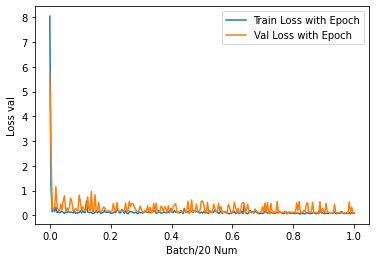

In [86]:
import matplotlib.pyplot as plt
fig,ax = plt.subplots()

x = np.linspace( 0, 1, len(train_loss))
ax.plot(x, train_loss, label='Train Loss with Epoch')
ax.plot(x, validation_loss ,label='Val Loss with Epoch')
ax.set_xlabel('Batch/20 Num')
ax.set_ylabel('Loss val')
ax.legend()
plt.show()

# Load Model


In [ ]:
encoder = model_utils.load_model(save_dir, 'encoder_06')
decoder = model_utils.load_model(save_dir, 'decoder_06')

/usr/local/lib/python3.7/dist-packages/torch/serialization.py:656: SourceChangeWarning: source code of class 'torch.nn.modules.linear.Linear' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)
/usr/local/lib/python3.7/dist-packages/torch/serialization.py:656: SourceChangeWarning: source code of class 'torch.nn.modules.rnn.LSTMCell' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)
/usr/local/lib/python3.7/dist-packages/torch/serialization.py:656: SourceChangeWarning: source code of class 'torch.nn.modules.dropout.Dropout' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch

In [87]:
data_test = pd.read_csv(processed_data_path + processed_data_files[-1])
input_seqsize = 20
rollout_len_test = 890

window_size_test = input_seqsize + rollout_len_test
data_temp = getConsecutive(data_test, window_size_test, DATA_STRIDE, FEATURE_SIZE)
model_input, state = getTestInput(data_temp, window_size_test, constant_)
test_dataset = TestDataset(model_input, state, None, input_seqsize, rollout_len_test)
test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=1)
test_utils = ModelUtils(save_dir, 1, lstm_hidden_size, gpu_bool=gpu_bool)

Add  (911, 5, 7)  data


RSME -- Acc      : 0.5340264889096795
RSME -- Yaw_rate : 0.010993662109945164
RSME -- Speed    : 8.30595495119677
RSME -- Yaw      : 0.03809490317500589
RSME -- Position : 158.13527743834473
 


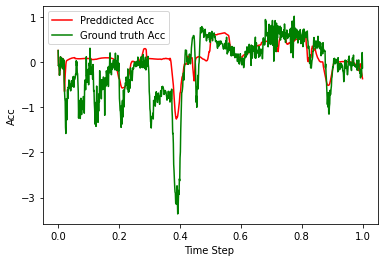

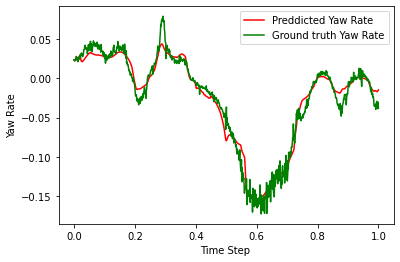

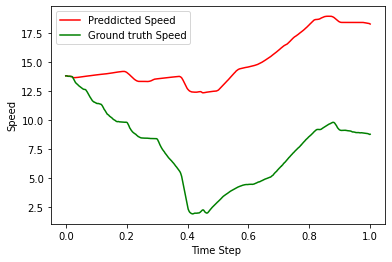

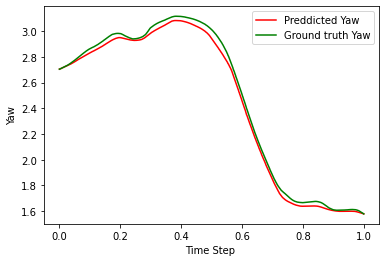

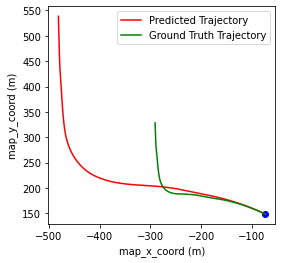

In [88]:
inputseq_len = input_seqsize
rollout_len = rollout_len_test

encoder.eval()
decoder.eval()

with torch.no_grad(): 
  for batch_index, data in enumerate(test_dataloader):

      predicted_acc = np.zeros(inputseq_len + rollout_len_test)
      predicted_yaw_rate = np.zeros(inputseq_len + rollout_len_test)

      predicted_speed = np.zeros(inputseq_len + rollout_len_test)
      predicted_yaw = np.zeros(inputseq_len + rollout_len_test)

      predicted_x = np.zeros(inputseq_len + rollout_len_test)
      predicted_y = np.zeros(inputseq_len + rollout_len_test)

      
      model_input, target, cumulated_state, command = data
      dT = cumulated_state[0, :, -1]
      # print(cumulated_state.shape)
      
      if gpu_bool:
              device = torch.device("cuda")
      else:
          device = torch.device("cpu")

      model_input = model_input.float().to(device)
      target = target.float().to(device)
      cumulated_state = cumulated_state.float().to(device)
      command = command.float().to(device)


      predicted_acc[:inputseq_len] = target[0, :inputseq_len, 0].cpu()
      predicted_yaw_rate[:inputseq_len] = target[0, :inputseq_len, 1].cpu()/constant_
      predicted_speed[:inputseq_len] = cumulated_state[0, :inputseq_len, -3].cpu()
      predicted_yaw[:inputseq_len] = cumulated_state[0, :inputseq_len, -2].cpu()
      predicted_x[:inputseq_len] = cumulated_state[0, :inputseq_len, 0].cpu()
      predicted_y[:inputseq_len] = cumulated_state[0, :inputseq_len, 1].cpu()

      for di in range(rollout_len):   
        # Initialize loss

        # Initialize encoder hidden state
        encoder_hidden = test_utils.init_zero_state()

        for ei in range(inputseq_len):
            encoder_hidden = encoder(model_input[:, ei, :], encoder_hidden)

        # Initialize decoder hidden state as encoder hidden state
        decoder_hidden = encoder_hidden

        decoder_input = model_input[:, input_seqlen - 1, :]
        decoder_output, decoder_hidden = decoder(decoder_input, decoder_hidden)

        new_in = torch.cat((command[:, di + inputseq_len, :], decoder_output), 1)
        new_in = new_in[None, :, :]
        model_input = torch.cat((model_input[:, 1:, :], new_in), 1)

        predicted_acc[inputseq_len + di] = decoder_output[0, 0]
        predicted_yaw_rate[inputseq_len + di] = decoder_output[0, 1]/constant_

        # predicted_speed[inputseq_len + di] = predicted_speed[inputseq_len + di - 1] +  target[0, inputseq_len + di - 1, 0].cpu()*dT[inputseq_len + di - 1]
        # predicted_yaw[inputseq_len + di] = predicted_yaw[inputseq_len + di - 1] +   target[0, inputseq_len + di - 1, 1].cpu()/10*dT[inputseq_len + di - 1]

        predicted_speed[inputseq_len + di] = predicted_speed[inputseq_len + di - 1] +  predicted_acc[inputseq_len + di - 1]*dT[inputseq_len + di - 1]
        predicted_yaw[inputseq_len + di] = predicted_yaw[inputseq_len + di - 1] +  predicted_yaw_rate[inputseq_len + di - 1]*dT[inputseq_len + di - 1]

        predicted_x[inputseq_len + di] = predicted_x[inputseq_len + di - 1] +  predicted_speed[inputseq_len + di - 1]*np.cos(predicted_yaw[inputseq_len + di - 1])*dT[inputseq_len + di - 1]
        predicted_y[inputseq_len + di] = predicted_y[inputseq_len + di - 1] +  predicted_speed[inputseq_len + di - 1]*np.sin(predicted_yaw[inputseq_len + di - 1])*dT[inputseq_len + di - 1]
        

      acc_pred = torch.from_numpy(predicted_acc[inputseq_len:])
      yaw_rate_pred = torch.from_numpy(predicted_yaw_rate[inputseq_len:])
      speed_pred = torch.from_numpy(predicted_speed[inputseq_len:])
      yaw_pred = torch.from_numpy(predicted_yaw[inputseq_len:])
      x_pred = torch.from_numpy(predicted_x[inputseq_len:])
      y_pred = torch.from_numpy(predicted_y[inputseq_len:])

      rsme_acc = torch.sqrt(criterion(target[:, inputseq_len:, 0].cpu(), acc_pred.unsqueeze(0)))
      rsme_yaw_rate = torch.sqrt(criterion(target[:, inputseq_len:, 1].cpu()/constant_, yaw_rate_pred.unsqueeze(0)))
      rsme_speed = torch.sqrt(criterion(cumulated_state[:, inputseq_len:, -3].cpu(), speed_pred.unsqueeze(0)))
      rsme_yaw = torch.sqrt(criterion(cumulated_state[:, inputseq_len:, -2].cpu(), yaw_pred.unsqueeze(0)))
      mse_x = criterion(cumulated_state[:, inputseq_len:, 0].cpu(), x_pred.unsqueeze(0))
      mse_y = criterion(cumulated_state[:, inputseq_len:, 1].cpu(), y_pred.unsqueeze(0))
      rsme_position = torch.sqrt(mse_x + mse_y)

      print(f"RSME -- Acc      : {rsme_acc}")
      print(f"RSME -- Yaw_rate : {rsme_yaw_rate}")
      print(f"RSME -- Speed    : {rsme_speed}")
      print(f"RSME -- Yaw      : {rsme_yaw}")
      print(f"RSME -- Position : {rsme_position}")
      print(' ')  

      visualize_result_state(predicted_acc, target[0, :, 0].cpu(), "Acc")
      visualize_result_state(predicted_yaw_rate, target[0, :, 1].cpu()/constant_, "Yaw Rate")
      visualize_result_state(predicted_speed, cumulated_state[0, :, 2].cpu(), "Speed")
      visualize_result_state(predicted_yaw, cumulated_state[0, :, 3].cpu(), "Yaw")
      visualize_result_position(predicted_x, predicted_y, cumulated_state[0, :, 0].cpu(), cumulated_state[0, :, 1].cpu())

      break

In [ ]:
def test(test_dataLoader,
         encoder,
         decoder,
         model_utils,
         criterion,
         inputseq_len,
         rollout_len,):
  
  encoder.eval()
  decoder.eval()



  with torch.no_grad(): 
    for batch_idx, data in enumerate(test_dataLoader):

      predcited_acc = []
      predcited_yaw_rate = []
      predicted_speed = []
      predcited_yaw = []
      predicted_x = []
      predicted_y = []
      
      model_input, target, cumulated_state = data
      if gpu_bool:
              device = torch.device("cuda")
          else:
              device = torch.device("cpu")

      model_input = model_input.float().to(device)

      target = target.float().to(device)
      cumulated_state = cumulated_state.float().to(device)


      original_input = model_input
      # Initialize loss
      loss = 0.0

      # Initialize encoder hidden state
      encoder_hidden = model_utils.init_zero_state()

      for ei in range(inputseq_len):
          encoder_hidden = encoder(original_input[:, ei, :], encoder_hidden)

      # Initialize decoder hidden state as encoder hidden state
      decoder_hidden = encoder_hidden

      decoder_input = model_input[:, input_seqlen - 1, :]
      decoder_output, decoder_hidden = decoder(decoder_input, decoder_hidden)

      predcited_state_list.append(decoder_output)

      # evaluation metric is RSME in 60 s prediction

  



2